## Setup Environment

In [1]:
!python -c "import monai" || pip install -q "monai-weekly[tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

## Setup Imports

In [2]:
import os
import csv
import sys
import time
import random
import shutil
import tempfile
import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch.cuda.amp import GradScaler, autocast

from monai.transforms import (
    Compose,
    Lambdad,
    Resized,
    Randomizable,
    EnsureChannelFirstd,
    ScaleIntensityRanged
)
from monai.config import print_config
from monai.utils import first, set_determinism
from monai.data import Dataset, CacheDataset, DataLoader

from PIL import Image
from tqdm import tqdm

from generative.inferers import DiffusionInferer
from generative.networks.nets import DiffusionModelUNet
from generative.networks.schedulers import DDPMScheduler

print_config()

MONAI version: 1.3.1rc2+1.g87152d10
Numpy version: 1.26.4
Pytorch version: 2.2.2+cu121
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 87152d106557bdc37de0ee923be4e9a25c4c003c
MONAI __file__: /data/<username>/jupyter/MONAI/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
ITK version: 5.3.0
Nibabel version: 5.2.1
scikit-image version: 0.22.0
scipy version: 1.11.4
Pillow version: 10.2.0
Tensorboard version: 2.16.2
gdown version: 4.7.3
TorchVision version: 0.17.2+cu121
tqdm version: 4.65.0
lmdb version: 1.4.1
psutil version: 5.9.0
pandas version: 2.1.4
einops version: 0.7.0
transformers version: 4.39.3
mlflow version: 2.11.3
pynrrd version: 1.0.0
clearml version: 1.15.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Setup Data Directory

In [3]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmpk9_ha6h8


## Set Deterministic Training for Reproducibility

In [4]:
set_determinism(42)

## CamcanDataset

In [5]:
class CamcanDataset(Randomizable, CacheDataset):
    def __init__(
        self,
        root_dir,
        csv_file,
        section,
        transform=None,
        seed=0,
        val_frac=0.2,
        test_frac=0.2,
        cache_num=sys.maxsize,
        cache_rate=1.0,
        num_workers=0,
        progress: bool = True,
        condition_prob = 0,
    ) -> None:
        if not os.path.isdir(root_dir):
            raise ValueError("Root directory root_dir must be a directory.")
        self.root_dir = root_dir
        self.csv_file = csv_file
        self.section = section
        self.val_frac = val_frac
        self.test_frac = test_frac
        self.condition_prob = condition_prob
        self.set_random_state(seed=seed)

        data = self._generate_data_list()

        CacheDataset.__init__(
            self,
            data=data,
            transform=transform,
            cache_num=cache_num,
            cache_rate=cache_rate,
            num_workers=num_workers,
            progress=progress,
        )

    def randomize(self, data: np.ndarray) -> None:
        self.R.shuffle(data)

    def _generate_data_list(self):
        datalist = []
        with open(self.csv_file, mode='r') as file:
            reader = csv.DictReader(file)
            for row in reader:
                image_path = os.path.join(self.root_dir, f"sub-{row['Subject']}_defaced_T1.nii.gz")
                if not os.path.exists(image_path):
                    continue
                img = nib.load(image_path)
                img_data = img.get_fdata()
                for slice_idx in range(img_data.shape[2]//2 - 20, img_data.shape[2]//2 + 20):  # Assuming axial slices
                    slice_data = img_data[:,:,slice_idx]
                    condition = np.array([
                        [int(row['Age'])],
                        [int(row['Sex'])],
                        [slice_idx]
                    ]).reshape((1,3)).astype('float32')
                    datalist.append({
                        "image": slice_data,
                        "condition": condition
                    })
        
        length = len(datalist)
        indices = np.arange(length)
        self.randomize(indices)

        # train, validation, test split
        test_length = int(length * self.test_frac)
        val_length = int(length * self.val_frac)
        if self.section == "test":
            section_indices = indices[:test_length]
        elif self.section == "validation":
            section_indices = indices[test_length : test_length + val_length]
        elif self.section == "training":
            section_indices = indices[test_length + val_length :]
        else:
            raise ValueError(
                f'Unsupported section: {self.section}, available options are ["training", "validation", "test"].'
            )
        return [datalist[i] for i in section_indices]

    def __getitem__(self, index):
        sample = self.data[index]

        if random.random() < self.condition_prob:
            sample["condition"] = np.array([[-1, -1, -1]])
        if self.transform:
            sample = self.transform(sample)
        return sample


## Setup CamcanDataset and Training and Validation DataLoader

In [6]:
# Usage example
data_dir = "./dataset_camcan_sy"
csv_file = "./phenotype.csv"

train_transforms = Compose(
    [
        EnsureChannelFirstd(keys=["image"], channel_dim='no_channel'),
        ScaleIntensityRanged(keys=["image"], a_min=0.0, a_max=255.0, b_min=0.0, b_max=1.0),
        Lambdad(keys=["condition"], func=lambda x: torch.tensor(x, dtype=torch.float32)),
        Resized(keys=["image"], spatial_size=(96,128)),
    ])


# Training DataLoader
train_ds = CamcanDataset(root_dir=data_dir, csv_file=csv_file, transform=train_transforms, section="training", condition_prob=0.2)
train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=8, persistent_workers=True)


Loading dataset: 100%|██████████| 15480/15480 [00:22<00:00, 689.53it/s]


In [7]:
val_transforms = Compose(
    [
        EnsureChannelFirstd(keys=["image"], channel_dim='no_channel'),
        ScaleIntensityRanged(keys=["image"], a_min=0.0, a_max=255.0, b_min=0.0, b_max=1.0),
        Lambdad(keys=["condition"], func=lambda x: torch.tensor(x, dtype=torch.float32)),
        Resized(keys=["image"], spatial_size=(96,128)),
    ]
)

# Validation DataLoader
val_ds = CamcanDataset(root_dir=data_dir, csv_file=csv_file, transform=val_transforms, section="validation")
val_loader = DataLoader(val_ds, batch_size=8, shuffle=False, num_workers=8, persistent_workers=True)

Loading dataset: 100%|██████████| 5160/5160 [00:07<00:00, 680.73it/s]


## Check Conditions are in place properly (age, slice_number)

In [8]:
'''
# Check Conditions are in place properly (age, slice_number)
df = pd.DataFrame(columns=['age', 'sex', 'slice_number'])
for data in train_loader:
    data_np = data['condition'].numpy()
    data_np = data_np.reshape(-1,3)
    df2 = pd.DataFrame(data_np, columns=['age', 'sex', 'slice_number'])
    df = pd.concat([df, df2], ignore_index=True)
df.to_csv("train_loader.csv", index=False)
'''

'\n# Check Conditions are in place properly (age, slice_number)\ndf = pd.DataFrame(columns=[\'age\', \'sex\', \'slice_number\'])\nfor data in train_loader:\n    data_np = data[\'condition\'].numpy()\n    data_np = data_np.reshape(-1,3)\n    df2 = pd.DataFrame(data_np, columns=[\'age\', \'sex\', \'slice_number\'])\n    df = pd.concat([df, df2], ignore_index=True)\ndf.to_csv("train_loader.csv", index=False)\n'

## Visualisation of Training Images

batch shape: torch.Size([8, 1, 96, 128])
metatensor([[[76.,  1., 28.]],

        [[88.,  2., 44.]],

        [[36.,  1., 62.]],

        [[32.,  2., 51.]],

        [[84.,  1., 50.]],

        [[42.,  2., 29.]],

        [[75.,  1., 59.]],

        [[30.,  1., 64.]]])
torch.Size([8, 1, 3])


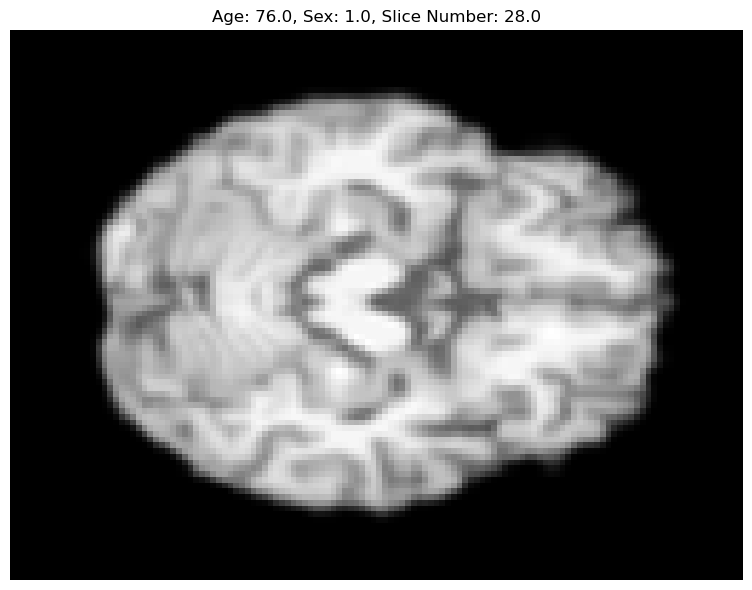

In [9]:
check_data = next(iter(train_loader))
print(f"batch shape: {check_data['image'].shape}")
first_image = check_data['image'][0, 0]  # Accessing the first image from the batch
condition = check_data['condition'][0] # Accessing the condition for the first image
print(check_data['condition'])
print(check_data['condition'].shape)

age = condition[0, 0]
sex = condition[0, 1]
slice_number = condition[0, 2]

# Plot the first image
plt.figure(figsize=(12, 6))
plt.imshow(first_image, cmap='gray')
plt.title(f"Age: {age}, Sex: {sex}, Slice Number: {slice_number}")
plt.axis('off')
plt.tight_layout()
plt.show()

## Define Network, Scheduler, Optimizer and Inferer

In [10]:
device = torch.device("cuda")

model = DiffusionModelUNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    num_channels=(256, 256, 512),
    attention_levels=(False, False, True),
    num_res_blocks=2,
    num_head_channels=(0, 0, 512),
    with_conditioning=True,
    cross_attention_dim=3,
)
model.to(device)

scheduler = DDPMScheduler(num_train_timesteps=1000)

optimizer = torch.optim.Adam(params=model.parameters(), lr=2.5e-5)

inferer = DiffusionInferer(scheduler)

## Pretrained Model

In [11]:
# Path to the pretrained model
pretrained_model_path = 'pretrained_model_200.pth'

# Load the state dictionary
state_dict = torch.load(pretrained_model_path, map_location=device)

# Load the state dictionary into the model
model.load_state_dict(state_dict)

# If you have a checkpoint with more information (like optimizer state), use this:
checkpoint = torch.load('pretrained_model_checkpoint_200.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
start_epoch = checkpoint['epoch']
print(start_epoch)

199


## Model Training

In [12]:
n_epochs = 75
val_interval = 25
epoch_loss_list = []
val_epoch_loss_list = []
epoch_loss_list = checkpoint['epoch_loss']
val_epoch_loss_list = checkpoint['val_epoch_loss']

end_epoch = start_epoch + 1 + n_epochs

scaler = GradScaler()
total_start = time.time()
for epoch in range(start_epoch+1, end_epoch):
    model.train()
    epoch_loss = 0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), ncols=70)
    progress_bar.set_description(f"Epoch {epoch}")
    for step, batch in progress_bar:
        images = batch["image"].to(device)
        conditions = batch["condition"].to(device)
        optimizer.zero_grad(set_to_none=True)

        with autocast(enabled=True):
            # Generate random noise
            noise = torch.randn_like(images).to(device)

            # Create timesteps
            timesteps = torch.randint(
                0, inferer.scheduler.num_train_timesteps, (images.shape[0],), device=images.device
            ).long()

            # Get model prediction
            noise_pred = inferer(inputs=images, diffusion_model=model, noise=noise, timesteps=timesteps, condition=conditions)
            loss = F.mse_loss(noise_pred.float(), noise.float())

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        epoch_loss += loss.item()

        progress_bar.set_postfix({"loss": epoch_loss / (step + 1)})
    epoch_loss_list.append(epoch_loss / (step + 1))

    if (epoch + 1) % val_interval == 0:
        model.eval()
        val_epoch_loss = 0
        for step, batch in enumerate(val_loader):
            images = batch["image"].to(device)
            conditions = batch["condition"].to(device)
            with torch.no_grad():
                with autocast(enabled=True):
                    noise = torch.randn_like(images).to(device)
                    timesteps = torch.randint(
                        0, inferer.scheduler.num_train_timesteps, (images.shape[0],), device=images.device
                    ).long()
                    noise_pred = inferer(inputs=images, diffusion_model=model, noise=noise, timesteps=timesteps, condition=conditions)
                    val_loss = F.mse_loss(noise_pred.float(), noise.float())

            val_epoch_loss += val_loss.item()
            progress_bar.set_postfix({"val_loss": val_epoch_loss / (step + 1)})
        val_epoch_loss_list.append(val_epoch_loss / (step + 1))
    
    torch.save(model.state_dict(), 'pretrained_model_275.pth')

# Optionally save a checkpoint with more information
checkpoint = {
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epoch': epoch,
    'epoch_loss': epoch_loss_list,
    'val_epoch_loss': val_epoch_loss_list,
}
torch.save(checkpoint, 'pretrained_model_checkpoint_275.pth')

total_time = time.time() - total_start
print(f"train completed, total time: {total_time}.")

Epoch 274: 100%|████| 1935/1935 [08:26<00:00,  3.82it/s, loss=0.00285]


train completed, total time: 38216.025074481964.


## Learning Curves

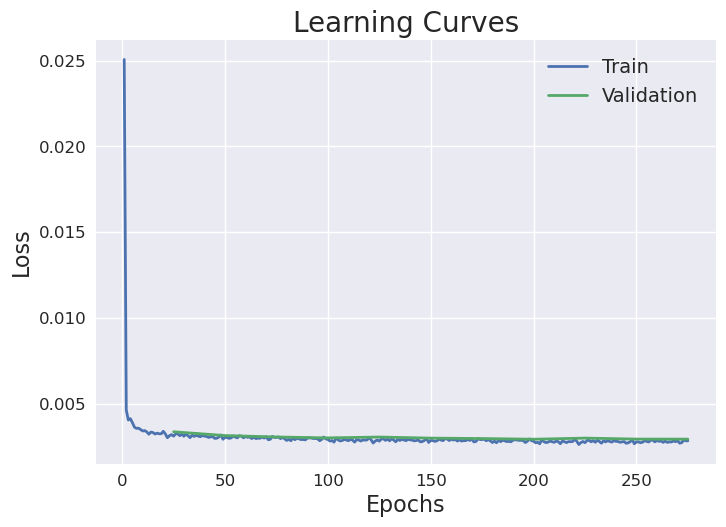

In [13]:
plt.style.use("seaborn-v0_8")
plt.title("Learning Curves", fontsize=20)
plt.plot(np.linspace(1, end_epoch, end_epoch), epoch_loss_list, color="C0", linewidth=2.0, label="Train")
plt.plot(
    np.linspace(val_interval, end_epoch, int(end_epoch / val_interval)),
    val_epoch_loss_list,
    color="C1",
    linewidth=2.0,
    label="Validation",
)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.xlabel("Epochs", fontsize=16)
plt.ylabel("Loss", fontsize=16)
plt.legend(prop={"size": 14})
plt.savefig('Learning_curves_275.png')
plt.show()

## Sampling Process With Classifier Free Guidance

100%|██████████| 1000/1000 [00:26<00:00, 37.30it/s]


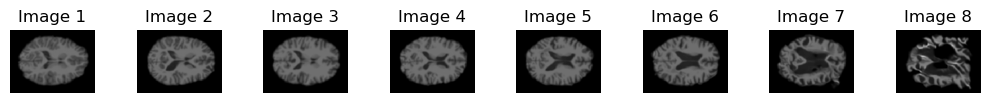

In [14]:
model.eval()
guidance_scale = 7.0

condition_set = [[18, 2, 45],
                [28, 1, 45],
                [38, 2, 45],
                [48, 1, 45],
                [58, 1, 45],
                [68, 1, 45],
                [78, 1, 45],
                [88, 1, 45]]
num_condition = len(condition_set)
conditioning = []

for case in condition_set:
    age, sex, slice_number = case
    # Create the conditioning tensors and reshape them to (1, 3)
    unconditioned = torch.tensor([[-1, -1, -1]], dtype=torch.float32)  # Shape: (1, 3)
    conditioned = torch.tensor([[age, sex, slice_number]], dtype=torch.float32)  # Shape: (1, 3)
    conditioning.append(torch.stack([unconditioned, conditioned], dim=0).to(device))

noise_cases = []

for idx in range(num_condition):
    noise = torch.randn((1, 1, 96, 128))
    noise = noise.to(device)
    scheduler.set_timesteps(num_inference_steps=1000)
    progress_bar = tqdm(scheduler.timesteps)
    
    case_conditioning = conditioning[idx]
    for t in progress_bar:
        with autocast(enabled=True):
            with torch.no_grad():
                noise_input = torch.cat([noise] * 2)
                model_output = model(noise_input, timesteps=torch.Tensor((t,)).to(noise.device), context=case_conditioning)
                noise_pred_uncond, noise_pred_text = model_output.chunk(2)
                noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        noise, _ = scheduler.step(noise_pred, t, noise)
    noise_cases.append(noise)

    # Save the raw noise image as a PNG file with scaling and grayscale
    noise_image = noise_cases[idx][0, 0].cpu().numpy()
    # Scale the data to 0-1
    noise_image = np.clip(noise_image, 0, 1)
    # Convert to 8-bit (0-255)
    noise_image = (noise_image * 255).astype(np.uint8)
    # Create and save the image using PIL
    img = Image.fromarray(noise_image, mode='L')
    img.save(f'noise_image_{idx + 1}.png')

plt.style.use("default")
plt.figure(figsize=(10,4))
for i in range(num_condition):
    plt.subplot(1, num_condition, i+1)
    plt.imshow(noise_cases[i][0, 0].cpu(), vmin=0, vmax=1, cmap="gray")
    plt.title(f"Image {i+1}")
    plt.tight_layout()
    plt.axis("off")

plt.show()

## Clean up Data Directory

In [15]:
if directory is None:
    shutil.rmtree(root_dir)